# Comparing first pipeline run results to KGML-xDTD embedding based results

The purpose of this notebook is to compare the performance of the models from the recent pipeline runs with the previous models using embeddings from the KGML-xDTD paper, as well as the first e2e pipeline run (from approx 14 August 2024) in which there was a bug in the evaluation pipeline. 

The notebook produces a table with the evaluation metrics for the models. See the bottom of the notebook. 

**Conclusions**: 

- We beat the old (internal) record for ranking metrics. This is a convincing indication we have competitive embeddings now.
- Comparing the scores for xg_ensemble, we see that we have clearly improved on the embeddings of the first run.
- The xg_synth scores for different embeddings suggest that our embeddings are still not quite as good as KGML-xDTD. This is not surprising since we are temporarily training with limited compute than Chunyu.
- The ensemble models have good ranking scores. Previously, we hadn’t tried combing the ensemble  technique with our other performance boosting method (BHO, large amount of synthesised negatives), so this a good sign.

In [1]:
import pandas as pd
import numpy as np
import joblib
import yaml

In [2]:
 %load_ext kedro.ipython

[08/29/24 21:04:45] INFO     Registered line magic '%reload_kedro'                                   ]8;id=875717;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=808249;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#58\58]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=406750;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=161035;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#60\60]8;;\

                    INFO     Resolved project path as:                                              ]8;id=236886;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=526132;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#171\171]8;;\
                             /Users/piotrkaniewski/work/matrix/pipelines/matrix.                                   
                             To set a different path, run '%reload_kedro <project_root>'                           

[08/29/24 21:04:46] INFO     Remembering context for spark later                                       ]8;id=961625;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/src/matrix/hooks.py\hooks.py]8;;\:]8;id=858953;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/src/matrix/hooks.py#162\162]8;;\

                    INFO     Registering new custom resolver: 'km.random_name'                    ]8;id=389885;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py\mlflow_hook.py]8;;\:]8;id=675331;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py#65\65]8;;\

[08/29/24 21:04:48] INFO     Kedro project matrix                                                   ]8;id=350426;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=917176;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#141\141]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=568777;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=550153;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#142\142]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=319348;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=682807;file:///Users/piotrkaniewski/work/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#148\148]8;;\

In [3]:
import pickle
import pandas as pd
import numpy as np
import sys

import matrix.datasets.pair_generator as pair_generator
from matrix.datasets.graph import KnowledgeGraph
from matrix.pipelines.evaluation.nodes import make_test_predictions, evaluate_test_predictions

## Input files

### Ground truth data with test-train splits

In [7]:
known_pairs = pd.read_parquet('/Users/alexei/Documents/data/e2e_14_aug/releases_20240807_05_model_input_splits')

### KGs with embeddings (KGML-xDTD, old run and new run)

In [16]:
with open('./input/rtx_kg2_nodes_chunyu', 'rb') as f:
    rtx_kg2 = pd.read_parquet(f)
rtx_kg2 = rtx_kg2.rename(columns={'embedding': 'topological_embedding'})
graph_chunyu = KnowledgeGraph(rtx_kg2)

In [10]:
with open('/Users/alexei/Documents/data/e2e_14_aug/releases_20240807_04_feature_rtx_kg2_nodes', 'rb') as f:
    rtx_kg2 = pd.read_parquet(f)
graph_first_run = KnowledgeGraph(rtx_kg2)

### Models

In [72]:
# Models using Chunyu's embeddings
xg_synth_chunyu = joblib.load('/Users/alexei/Documents/repos/matrix/pipelines/matrix/notebooks/scratch/local/generate_matrix/input/xg_balanced_retrain.joblib')
rf_chunyu = joblib.load('/Users/alexei/Documents/repos/matrix/pipelines/matrix/notebooks/scratch/local/misc/train-kgml-xdtd/output/kgml_xdtd_split.joblib')

In [24]:
# Model using embeddings from first run
with open("/Users/alexei/Documents/data/e2e_14_aug/releases_20240807_06_models_xgc_model.pickle", "rb") as f:
    xg_ensemble_first_run = pickle.load(f)

### Other objects needed

In [43]:
# Load model params
with open('/Users/alexei/Documents/repos/matrix/pipelines/matrix/conf/base/modelling/parameters/defaults.yml', 'r') as f:
    model_params_defaults = yaml.safe_load(f)

In [49]:
# Load objects needed for predictions
score_col_name = 'treat score'
features = model_params_defaults['_model_options']['model_tuning_args']['features']
transformers = model_params_defaults['_model_options']['transformers']

In [61]:
# Load drug flags
with open('/Users/alexei/Documents/repos/matrix/pipelines/matrix/conf/base/modelling/parameters/xg_baseline.yml', 'r') as f:
    model_params_baseline = yaml.safe_load(f)
drug_flags = model_params_baseline['modelling.xg_baseline']['_overrides']['generator']['drug_flags']


## Predictions

### Disease-centric matrix

In [105]:
# Generating disease-centric matrix
matrix = pair_generator.MatrixTestDiseases(drug_flags)
matrix = matrix.generate(graph_first_run, known_pairs)

100%|██████████| 1133/1133 [00:00<00:00, 8038.19it/s]


In [106]:
# Making predictions
data = matrix.copy()
mat_preds_xg_synth_chunyu = make_test_predictions(graph_chunyu, data, transformers, xg_synth_chunyu, features, score_col_name)
data = matrix.copy()
mat_preds_rf_chunyu = make_test_predictions(graph_chunyu, data, transformers, rf_chunyu, features, score_col_name)
data = matrix.copy()
mat_preds_xg_ensemble_first_run = make_test_predictions(graph_first_run, data, transformers, xg_ensemble_first_run, features, score_col_name)

100%|██████████| 1133/1133 [08:44<00:00,  2.16it/s]


### Ground truth test set

In [107]:
gt_data  = pair_generator.GroundTruthTestPairs()
gt_data = gt_data.generate(graph_first_run, known_pairs)

In [108]:
# Making predictions
data = gt_data.copy()
gt_preds_xg_synth_chunyu = make_test_predictions(graph_chunyu, data, transformers, xg_synth_chunyu, features, score_col_name)
data = gt_data.copy()
gt_preds_rf_chunyu = make_test_predictions(graph_chunyu, data, transformers, rf_chunyu, features, score_col_name)
data = gt_data.copy()
gt_preds_xg_ensemble_first_run = make_test_predictions(graph_first_run, data, transformers, xg_ensemble_first_run, features, score_col_name)

100%|██████████| 1510/1510 [00:18<00:00, 81.43it/s]


## Computing evaluation metrics

In [109]:
# Loading evaluation options from the catalog
with open('/Users/alexei/Documents/repos/matrix/pipelines/matrix/conf/base/evaluation/parameters.yml', 'r') as f:
    eval_params = yaml.safe_load(f)
spec_ranking_options = eval_params['evaluation.disease_specific_ranking']['evaluation_options']['evaluation']
mat_ranking_options = eval_params['evaluation.disease_centric_matrix']['evaluation_options']['evaluation']
classification_options = eval_params['evaluation.simple_ground_truth_classification']['evaluation_options']['evaluation']

In [110]:
# Computing metrics with the pipeline
spec_ranking_xg_synth_chunyu = evaluate_test_predictions(mat_preds_xg_synth_chunyu, spec_ranking_options)
mat_ranking_xg_synth_chunyu = evaluate_test_predictions(mat_preds_xg_synth_chunyu, mat_ranking_options)
classification_xg_synth_chunyu = evaluate_test_predictions(gt_preds_xg_synth_chunyu, classification_options)
spec_ranking_rf_chunyu = evaluate_test_predictions(mat_preds_rf_chunyu, spec_ranking_options)
mat_ranking_rf_chunyu = evaluate_test_predictions(mat_preds_rf_chunyu, mat_ranking_options)
classification_rf_chunyu = evaluate_test_predictions(gt_preds_rf_chunyu, classification_options)
spec_ranking_xg_ensemble_first_run = evaluate_test_predictions(mat_preds_xg_ensemble_first_run, spec_ranking_options)
mat_ranking_xg_ensemble_first_run = evaluate_test_predictions(mat_preds_xg_ensemble_first_run, mat_ranking_options)
classification_xg_ensemble_first_run = evaluate_test_predictions(gt_preds_xg_ensemble_first_run, classification_options)

100%|██████████| 1133/1133 [01:23<00:00, 13.64it/s]


## Overview of results

In [ ]:
model_name_lst = ['xg_synth_chunyu', 'rf_chunyu', 'xg_ensemble_first_run']
metric_name_lst = ['auroc', 'ap', 'mrr', 'hit2', 'hit10', 'hit100', 'acc', 'f1']
auroc_lst = [eval('mat_ranking_'+model_name)['roc_auc_score'] for model_name in model_name_lst]
ap_lst = [eval('mat_ranking_'+model_name)['average_precision_score'] for model_name in model_name_lst]
mrr_lst = [eval('spec_ranking_'+model_name)['mrr'] for model_name in model_name_lst]
hit2_lst = [eval('spec_ranking_'+model_name)['hit-2'] for model_name in model_name_lst]
hit10_lst = [eval('spec_ranking_'+model_name)['hit-10'] for model_name in model_name_lst]
hit100_lst = [eval('spec_ranking_'+model_name)['hit-100'] for model_name in model_name_lst]
acc_lst = [eval('classification_'+model_name)['accuracy_score'] for model_name in model_name_lst]
f1_lst = [eval('classification_'+model_name)['f1_score'] for model_name in model_name_lst]

In [39]:
# Tedious manual input of latest results (new run 26 Aug)

results_xg_ensemble_new_run_3 = {'auroc': 0.9219692860724151,
'ap': 0.043389910213820035,
'mrr': 0.19728144176219592,
'hit2': 0.17863805970149255,
'hit10': 0.314365671641791,
'hit100': 0.6203358208955224,
'acc': 0.8574043565806333,
'f1': 0.7843897038472184
}
results_xg_synth_new_run_3 = {
'auroc': 0.8383403010392563,
'ap': 0.007503326148252967,
'mrr': 0.10459264807623478,
'hit2': 0.08861940298507463,
'hit10': 0.17583955223880596,
'hit100': 0.4398320895522388,
'acc': 0.9101226432363171,
'f1': 0.8768497617256082
}
results_xg_ensemble_new_run_6 = {
'mrr': 0.14736130097929595,
'hit2': 0.13013059701492538,
'hit10': 0.2462686567164179,
'hit100': 0.554570895522388,
'auroc': 0.9055752875277525,
'ap': 0.028384013211504897,
'acc': 0.8411129416071755,
'f1': 0.7535491198182851
}
results_xg_synth_new_run_6 = {'ap': 0.005491298670828154,
'hit100': 0.376865671641791,
'auroc': 0.8248684530632286,
'mrr': 0.06576272993950255,
'hit2': 0.05177238805970149,
'hit10': 0.11800373134328358,
'acc': 0.9038989566172433,
'f1': 0.8678580417820287
}

In [46]:
# added by piotr
model_name_list = ['xg_ensemble_new_run_1', 'xg_synth_new_run_1','xg_ensemble_new_run_3', 'xg_synth_new_run_3', 'xg_ensemble_new_run_4', 'xg_synth_new_run_4','xg_ensemble_new_run_5', 'xg_synth_new_run_5','xg_ensemble_new_run_6', 'xg_synth_new_run_6']
model_name_list = [eval('results_' + model_name) for model_name in model_name_list]
df_new_runs = pd.concat(model_name_list)

In [47]:
# added by piotr
df_all_runs = pd.concat([df_chunyu,df_new_runs])

In [ ]:
[model_name_lst = 'xg_ensemble_new_run_1', 'xg_synth_new_run_1','xg_ensemble_new_run_4', 'xg_synth_new_run_4','xg_ensemble_new_run_5', 'xg_synth_new_run_5','xg_ensemble_new_run_3', 'xg_synth_new_run_3', 'xg_ensemble_new_run_6', 'xg_synth_new_run_6']
for model_name in model_name_lst[:]:
    for metric_name in metric_name_lst:
        eval(metric_name + '_lst').append(eval('results_' + model_name)[metric_name])

In [ ]:
results_df = pd.DataFrame({metric_name: eval(metric_name + '_lst') for metric_name in metric_name_lst}, index=model_name_lst)

In [70]:
# Function to highlight the best model for each metric
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styled_df = df_all_runs.style.apply(highlight_max, axis=0)
styled_df

,auroc,ap,mrr,hit2,hit10,hit100,acc,f1
xg_synth_chunyu,0.867708,0.019273,0.153431,0.132929,0.271455,0.578358,0.926231,0.900074
rf_chunyu,0.741243,0.006884,0.129286,0.120336,0.197295,0.423041,0.882482,0.833420
xg_ensemble_first_run,0.844903,0.008687,0.068847,0.047575,0.132929,0.398787,0.782720,0.629410
xg_ensemble_new_run_3,0.921969,0.043390,0.197281,0.178638,0.314366,0.620336,0.857404,0.784390
xg_synth_new_run_3,0.838340,0.007503,0.104593,0.088619,0.175840,0.439832,0.910123,0.876850
xg_ensemble_new_run_6,0.905575,0.028384,0.147361,0.130131,0.246269,0.554571,0.841113,0.753549
xg_synth_new_run_6,0.824868,0.005491,0.065763,0.051772,0.118004,0.376866,0.903899,0.867858


### Continued by Piotr - 29-08-2024
Now that we have most results (except for setup 2), I will compare them all incl. PCA plots (stored in MLFlow)

In [63]:
#recreating
df_chunyu = pd.DataFrame({
    'auroc': [0.867708, 0.741243, 0.844903],
    'ap': [0.019273, 0.006884, 0.008687],
    'mrr': [0.153431, 0.129286, 0.068847],
    'hit2': [0.132929, 0.120336, 0.047575],
    'hit10': [0.271455, 0.197295, 0.132929],
    'hit100': [0.578358, 0.423041, 0.398787],
    'acc': [0.926231, 0.882482, 0.782720],
    'f1': [0.900074, 0.833420, 0.629410]
}, index=['xg_synth_chunyu', 'rf_chunyu', 'xg_ensemble_first_run'])


In [59]:
# Tedious manual input of latest results (new run 26 Aug)
# updated by piotr (29-08-2024)

results_xg_ensemble_new_run_3 = pd.DataFrame({'auroc': 0.9219692860724151,
'ap': 0.043389910213820035,
'mrr': 0.19728144176219592,
'hit2': 0.17863805970149255,
'hit10': 0.314365671641791,
'hit100': 0.6203358208955224,
'acc': 0.8574043565806333,
'f1': 0.7843897038472184
}, index=['xg_ensemble_new_run_3'])
results_xg_synth_new_run_3 = pd.DataFrame({
'auroc': 0.8383403010392563,
'ap': 0.007503326148252967,
'mrr': 0.10459264807623478,
'hit2': 0.08861940298507463,
'hit10': 0.17583955223880596,
'hit100': 0.4398320895522388,
'acc': 0.9101226432363171,
'f1': 0.8768497617256082
}, index=['xg_synth_new_run_3'])

results_xg_ensemble_new_run_6 = pd.DataFrame({
'mrr': 0.14736130097929595,
'hit2': 0.13013059701492538,
'hit10': 0.2462686567164179,
'hit100': 0.554570895522388,
'auroc': 0.9055752875277525,
'ap': 0.028384013211504897,
'acc': 0.8411129416071755,
'f1': 0.7535491198182851
}, index=['xg_ensemble_new_run_6'])
results_xg_synth_new_run_6 = pd.DataFrame({'ap': 0.005491298670828154,
'hit100': 0.376865671641791,
'auroc': 0.8248684530632286,
'mrr': 0.06576272993950255,
'hit2': 0.05177238805970149,
'hit10': 0.11800373134328358,
'acc': 0.9038989566172433,
'f1': 0.8678580417820287
}, index=['xg_synth_new_run_6'])


In [64]:
# updated by piotr (29-08-2024)
# Tedious manual input of latest results (new run 26 Aug)

results_xg_ensemble_new_run_1 = pd.DataFrame({'auroc': 0.9205314905728452,
'ap': 0.019094170910145973,
'mrr': 0.1327579085776529,
'hit2': 0.11847014925373134,
'hit10': 0.21315298507462688,
'hit100': 0.4855410447761194,
'acc': 0.7913234486545854,
'f1': 0.5530636737628546,
}, index=['xg_ensemble_new_run_1'])

results_xg_synth_new_run_1 = pd.DataFrame({
'auroc': 0.938394157682914,
'ap': 0.00311571370242041,
'mrr': 0.04100465783353993,
'hit2': 0.032182835820895525,
'hit10': 0.07136194029850747,
'hit100': 0.28451492537313433,
'acc': 0.8795533589602782,
'f1': 0.5898006125192427
}, index=['xg_synth_new_run_1'])

results_xg_ensemble_new_run_4 = pd.DataFrame({
'mrr': 0.19004647175750133,
'hit2': 0.16511194029850745,
'hit10': 0.3162313432835821,
'hit100': 0.6324626865671642,
'auroc': 0.9691564117496279,
'ap': 0.04163573984107834,
'acc': 0.8378180486911954,
'f1': 0.5825615645694927
}, index=['xg_ensemble_new_run_4'])
results_xg_synth_new_run_4 = pd.DataFrame({
'ap': 0.008760532171652465,
'hit100': 0.46548507462686567,
'auroc': 0.9755692012969199,
'mrr': 0.11174423545734395,
'hit2': 0.09188432835820895,
'hit10': 0.19682835820895522,
'acc': 0.9104887424492037,
'f1': 0.6150820759908692
}, index=['xg_synth_new_run_4'])

results_xg_ensemble_new_run_5 = pd.DataFrame({
'mrr': 0.14120923929593135,
'hit2': 0.1226679104477612,
'hit10': 0.25046641791044777,
'hit100': 0.5783582089552238,
'auroc': 0.9496864937143991,
'ap': 0.027617631373212527,
'acc': 0.8310452132527915,
'f1': 0.5783746628159361
}, index=['xg_ensemble_new_run_5'])

results_xg_synth_new_run_5 = pd.DataFrame({
'ap': 0.006890048606767505,
'hit100': 0.40671641791044777,
'auroc': 0.957490908150954,
'mrr': 0.07863691385785539,
'hit2': 0.06343283582089553,
'hit10': 0.14412313432835822,
'acc': 0.9022515101592532,
'f1': 0.6104670872531631
}, index=['xg_synth_new_run_5'])


In [65]:
model_name_list = ['xg_ensemble_new_run_1', 'xg_synth_new_run_1','xg_ensemble_new_run_3', 'xg_synth_new_run_3', 'xg_ensemble_new_run_4', 'xg_synth_new_run_4','xg_ensemble_new_run_5', 'xg_synth_new_run_5','xg_ensemble_new_run_6', 'xg_synth_new_run_6']
model_name_list = [eval('results_' + model_name) for model_name in model_name_list]
df_new_runs = pd.concat(model_name_list)

In [66]:
df_all_runs = pd.concat([df_chunyu,df_new_runs])

In [67]:
# Function to highlight the best model for each metric
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styled_df = df_all_runs.style.apply(highlight_max, axis=0)
styled_df

,auroc,ap,mrr,hit2,hit10,hit100,acc,f1
xg_synth_chunyu,0.867708,0.019273,0.153431,0.132929,0.271455,0.578358,0.926231,0.900074
rf_chunyu,0.741243,0.006884,0.129286,0.120336,0.197295,0.423041,0.882482,0.833420
xg_ensemble_first_run,0.844903,0.008687,0.068847,0.047575,0.132929,0.398787,0.782720,0.629410
xg_ensemble_new_run_1,0.920531,0.019094,0.132758,0.118470,0.213153,0.485541,0.791323,0.553064
xg_synth_new_run_1,0.938394,0.003116,0.041005,0.032183,0.071362,0.284515,0.879553,0.589801
xg_ensemble_new_run_3,0.921969,0.043390,0.197281,0.178638,0.314366,0.620336,0.857404,0.784390
xg_synth_new_run_3,0.838340,0.007503,0.104593,0.088619,0.175840,0.439832,0.910123,0.876850
xg_ensemble_new_run_4,0.969156,0.041636,0.190046,0.165112,0.316231,0.632463,0.837818,0.582562
xg_synth_new_run_4,0.975569,0.008761,0.111744,0.091884,0.196828,0.465485,0.910489,0.615082
xg_ensemble_new_run_5,0.949686,0.027618,0.141209,0.122668,0.250466,0.578358,0.831045,0.578375


## PCA plots examination 

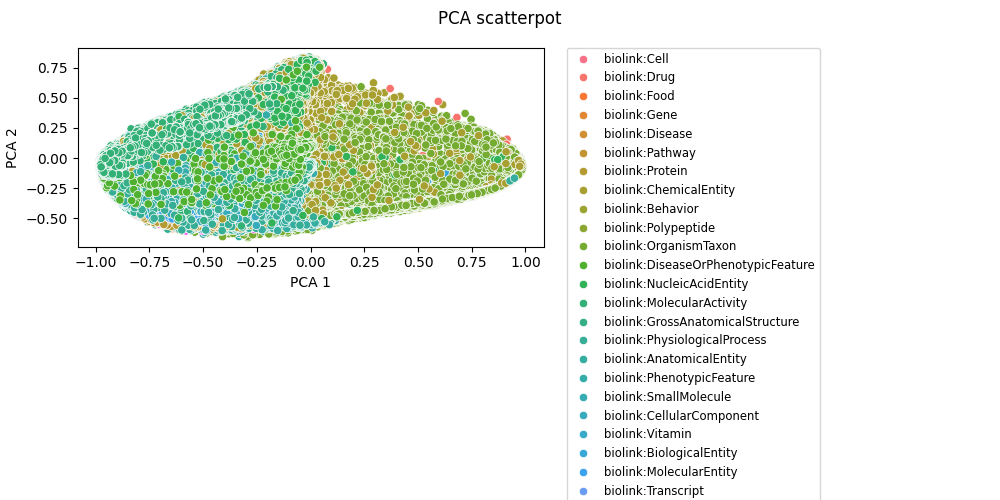

In [51]:
from PIL import Image
Image.open('scratch/pca_1.png')

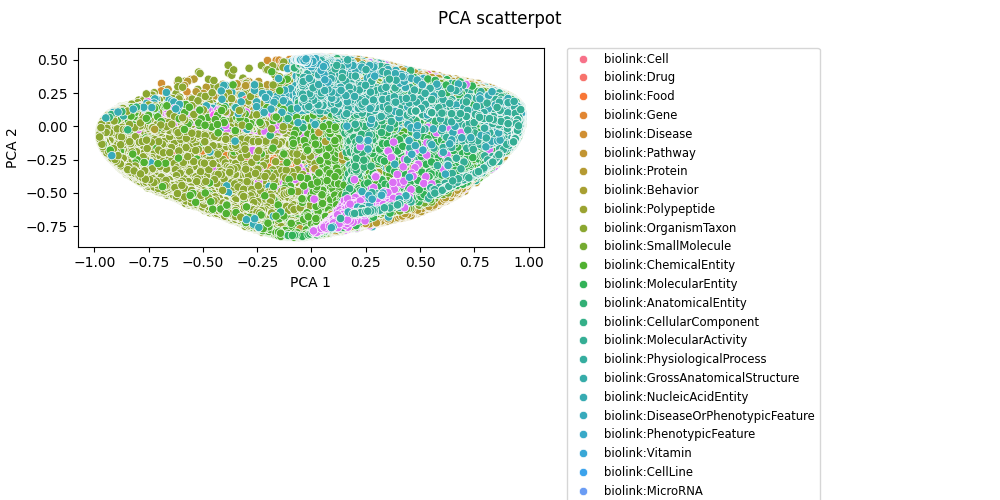

In [52]:
from PIL import Image
Image.open('scratch/pca_2.png')

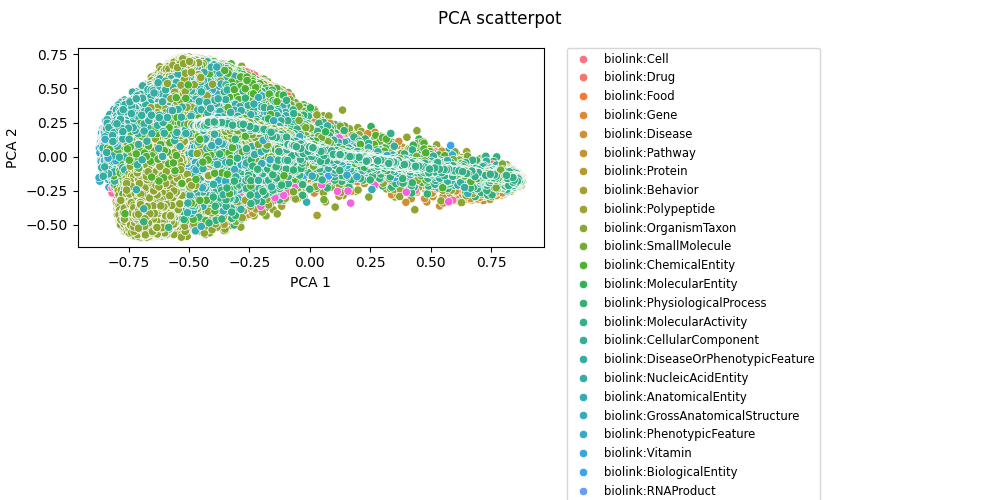

In [53]:
from PIL import Image
Image.open('scratch/pca_3.png')

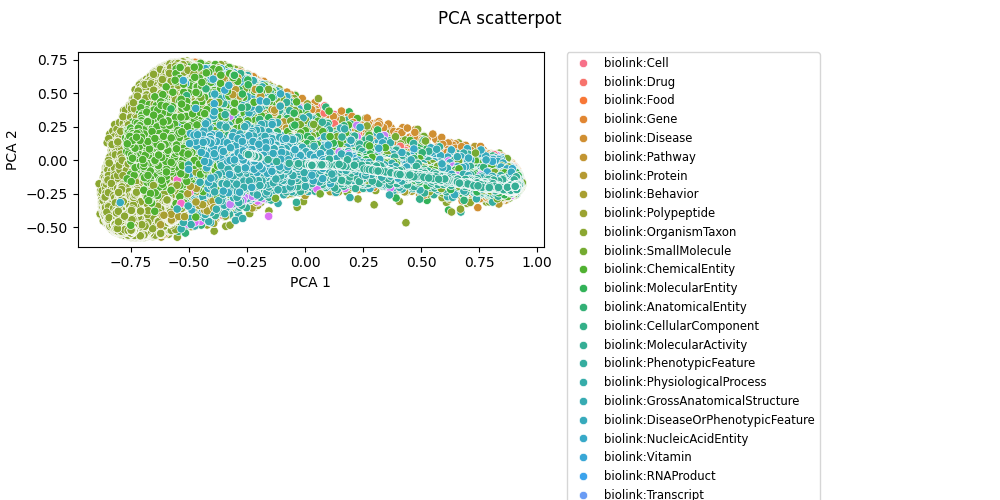

In [71]:
from PIL import Image
Image.open('scratch/pca_4.png')

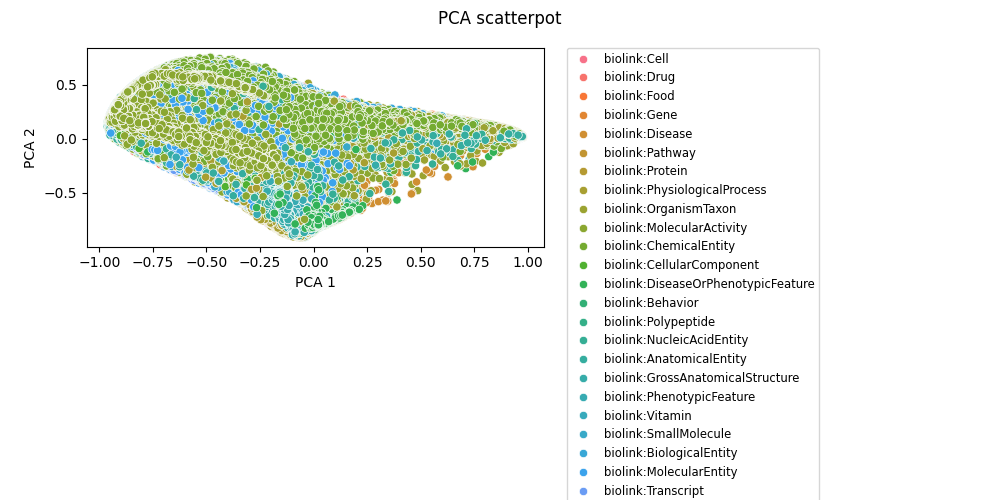

In [55]:
from PIL import Image
Image.open('scratch/pca_5.png')

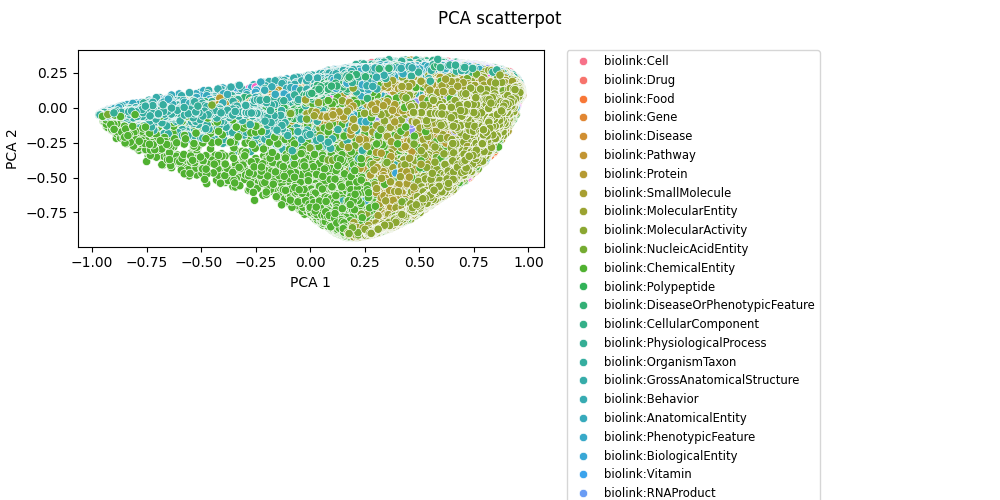

In [56]:
from PIL import Image
Image.open('scratch/pca_6.png')

PCAs look much better, no parabolic shapes, with clusters being the most visible for setups 5 and 6. PCAs from setup 3 and 4 are a bit more mixed which could be due to lower learning rate/higher number of iterations. PCAs from setups 1 and 2 are the most similar to Chunyus. We need to note though that PCAs are not indicative of downstream task performance and at the end of the day, its only model performance that matters.

Nevertheless, the problem of wiggly spaghetti-like PCAs is now solved and could be assinged to the sigmoid activation function

## Summary

Best results were achieved by ensemble models from run 3 and run 4; the results by these two setups are comparable for majority of metrics but setup 3 was superior in terms of F1 score where setup 4 scored much lower. Setups 3 and 4 had different search depth (100 vs 4) showing that it is not a significant factor in the performance (at least for our case). Both setups 3 and 4 had **learning rate 0.01** (lr of 0.1 was likely too high, leading to worse performance of setup 1, 5, and 6).  Both setup 3 and setup 4 also had **max iter 100**, meaning that now that we have ReLU activation, longer training is not necessarily bad. While remaining setups did have higher learning rate and lower number of max iteration (0.1 and 10 respectively), lets remember that with lower learning rate we need to have higher number of iterations/epochs as our 'steps' during weights optimization are smaller.

In terms of Sample size - while we dont have results from setup 2 to compare, setup 1 (25,10) and setup 5 (96,96) show the effect of increasing the sample size per layer. Setup 5 achieved better results across all metrics than setup 1 did, **potentially showing that sampleSize [96,96] is more optimal for our use case** (thats the same one that Chunyu used). It would be interesting to see if setups 3 and setup 4 performance would improve upon having such sample size.

In summary, we are at a good place with the embeddings as Alexei has mentioned - GraphSAGE is now optimized well (however there is likely some room for improvement)

## Experimental setups (for reference)

#### Experiment Setups

    ##### setup 1 
    activation: ReLU
    maxIterations: 10
    epochs: 10
    learningRate: 0.1
    sampleSizes: [25, 10]
    searchDepth: 100

    ##### setup 2 
    activation: ReLU
    maxIterations: 10
    epochs: 10
    learningRate: 0.1
    sampleSizes: [25, 10]
    searchDepth: 4

    ##### setup 3 
    activation: ReLU
    maxIterations: 100
    epochs: 10
    learning rate - 0.01
    sampleSizes - [25, 10]
    searchDepth: 100

    ##### setup 4
    activation: ReLU
    maxIterations: 100
    epochs: 10
    learning rate - 0.01
    sampleSizes - [25, 10]
    searchDepth: 4

    ##### setup 5 
    activation: ReLU
    maxIterations: 10
    epochs: 10
    learningRate: 0.1
    sampleSizes: [96, 96]
    searchDepth: 100

    ##### setup 6 
    activation: ReLU
    maxIterations: 10
    epochs: 10
    learningRate: 0.1
    sampleSizes: [96, 96]
    searchDepth: 4


#### Potential next experiments

To ensure what the optimal number of max iterations are 

    ##### setup 3
    activation: ReLU
    maxIterations: 10
    epochs: 10
    learning rate - 0.01
    sampleSizes - [25, 10]
    searchDepth: 100

    ##### setup 1 
    activation: ReLU
    maxIterations: 100
    epochs: 10
    learningRate: 0.1
    sampleSizes: [25, 10]
    searchDepth: 100


To see the effect of SampleSize

    ##### setup 3
    activation: ReLU
    maxIterations: 100
    epochs: 10
    learning rate - 0.01
    sampleSizes - [96, 96]
    searchDepth: 100


    ##### setup 4
    activation: ReLU
    maxIterations: 100
    epochs: 10
    learning rate - 0.01
    sampleSizes - [96, 96]
    searchDepth: 4